In [5]:
%load_ext autoreload
%autoreload 2

import sys, os
from pydrake.all import StartMeshcat

# if you're not launching jupyter from the repo root, fix the path:
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

meshcat = StartMeshcat()
print("Meshcat:", meshcat.web_url())

INFO:drake:Meshcat listening for connections at http://localhost:7000


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Meshcat: http://localhost:7000


### Import URDF, Build both Robots, Define Frame


In [23]:
import os
import numpy as np
from pydrake.all import StartMeshcat
from pydrake.multibody.tree import RevoluteJoint
from rocky.build import build_robot_diagram_two
from rocky.ilqr import ILQRController, CostParams
from rocky.dynamics import ArmParams, forward_kinematics

rng = np.random.default_rng()

# --- URDF ---
urdf = "../rocky.urdf"

# --- Joint helpers ---
def get_revolute_joints_for_instance(plant, instance):
    joints = [plant.get_joint(j) for j in plant.GetJointIndices(instance)]
    return [j for j in joints if isinstance(j, RevoluteJoint)]


def set_angles_for_instance(plant, ctx, instance, angles_rad):
    revs = get_revolute_joints_for_instance(plant, instance)
    for j, q in zip(revs, angles_rad):
        j.set_angle(ctx, float(q))


def set_zero_torques(plant, ctx):
    plant.get_actuation_input_port().FixValue(ctx, np.zeros(plant.num_actuators()))


def get_ally_state(plant, ctx, ally):
    q = plant.GetPositions(ctx, ally)[:2]
    dq = plant.GetVelocities(ctx, ally)[:2]
    return np.hstack([q, dq])


def get_enemy_state(plant, ctx, enemy):
    q = plant.GetPositions(ctx, enemy)[:2]
    dq = plant.GetVelocities(ctx, enemy)[:2]
    return np.hstack([q, dq])

# --------------------------------------------------------------------
# Coordinate-frame utilities
# --------------------------------------------------------------------

def get_shoulder_in_world(plant, ctx, wall_frame):
    X_W_wall = plant.CalcRelativeTransform(ctx, W, wall_frame)
    shoulder_in_wall = np.array([0.0, 0.0, 1.0])   # joint origin in wall frame
    return X_W_wall.translation() + X_W_wall.rotation().matrix() @ shoulder_in_wall


def express_point_in_wall_2d(plant, ctx, wall_frame, p_W_point, p_W_shoulder):
    # Point in wall frame
    X_wall_W = plant.CalcRelativeTransform(ctx, wall_frame, W)
    p_wall_point    = X_wall_W.multiply(p_W_point)
    p_wall_shoulder = X_wall_W.multiply(p_W_shoulder)
    rel = p_wall_point - p_wall_shoulder
    # 2D planar coordinates: (x,z)
    return np.array([rel[0], rel[2]])


def get_ally_shoulder_in_world(plant, ctx):
    return get_shoulder_in_world(plant, ctx, ally_wall_frame)


def get_enemy_shoulder_in_world(plant, ctx):
    return get_shoulder_in_world(plant, ctx, enemy_wall_frame)

# --------------------------------------------------------------------
# Ally’s view (coordinates in Ally wall / shoulder frame)
# --------------------------------------------------------------------

def get_ally_target_pos_2d(plant, ctx):
    """
    Ally's target: the 'enemy_target' sphere on the ENEMY side,
    expressed in Ally wall frame (2D x,z).
    """
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, enemy_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_T, p_W_shoulder)


def get_enemy_pos_2d(plant, ctx):
    """
    Enemy EE expressed in Ally wall frame (2D x,z).
    Used when Ally is attacking or defending.
    """
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_EE = plant.CalcRelativeTransform(ctx, W, enemy_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_EE, p_W_shoulder)


def get_enemy_target_pos_2d_for_ally(plant, ctx):
    """
    Enemy's target ('ally_target' sphere near Ally wall),
    expressed in Ally wall frame (2D x,z).
    Used when Ally is blocking the Enemy's strike.
    """
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, ally_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_T, p_W_shoulder)

# --------------------------------------------------------------------
# Enemy’s view (coordinates in Enemy wall / shoulder frame)
# --------------------------------------------------------------------

def get_enemy_target_pos_2d_for_enemy(plant, ctx):
    """
    Enemy's target: the 'ally_target' sphere near the ALLY wall,
    expressed in Enemy wall frame (2D x,z).
    """
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, ally_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_T, p_W_shoulder)


def get_ally_pos_2d_for_enemy(plant, ctx):
    """
    Ally EE expressed in Enemy wall frame (2D x,z).
    Used for Enemy's avoidance / planning.
    """
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_ally = plant.CalcRelativeTransform(ctx, W, ally_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_ally, p_W_shoulder)


def get_enemy_pos_2d_for_enemy(plant, ctx):
    """
    Enemy EE expressed in Enemy wall frame (2D x,z).
    Used both for control and hit detection on Enemy side.
    """
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_enemy = plant.CalcRelativeTransform(ctx, W, enemy_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_enemy, p_W_shoulder)

# --------------------------------------------------------------------
# Model forward kinematics (local shoulder frame)
# --------------------------------------------------------------------

def get_ally_pos_2d_from_model(x, params):
    return forward_kinematics(x[:2], params)


def get_enemy_pos_2d_from_model(x, params):
    return forward_kinematics(x[:2], params)


def apply_combined_torques(u_ally=None, u_enemy=None):
    tau = np.zeros(plant.num_actuators())
    if u_ally is not None:
        tau[ally_act_idxs[0]] = u_ally[0]
        tau[ally_act_idxs[1]] = u_ally[1]
    if u_enemy is not None:
        tau[enemy_act_idxs[0]] = u_enemy[0]
        tau[enemy_act_idxs[1]] = u_enemy[1]
    plant.get_actuation_input_port().FixValue(ctx, tau)


def apply_ally_torque(plant, ctx, ally, u2):
    apply_combined_torques(u_ally=u2, u_enemy=None)


def apply_enemy_torque(plant, ctx, enemy, u2):
    apply_combined_torques(u_ally=None, u_enemy=u2)

def get_ally_target_pos_2d(plant, plant_ctx):
    """
    Target for the Ally to punch (on the enemy side).
    Uses the frame named 'enemy_target' at x ≈ 1.0.
    """
    frame = plant.GetFrameByName("enemy_target")  # Ally's target on enemy side
    X_WT = frame.CalcPoseInWorld(plant_ctx)
    p = X_WT.translation()
    return np.array([p[0], p[2]])  # (x, z) for planar 2D


def get_enemy_target_pos_2d_for_enemy(plant, plant_ctx):
    """
    Target for the Enemy to punch (on the ally side, near the wall).
    Uses the frame named 'ally_target' at x ≈ 0.15.
    """
    frame = plant.GetFrameByName("ally_target")   # Enemy's target on ally side
    X_WT = frame.CalcPoseInWorld(plant_ctx)
    p = X_WT.translation()
    return np.array([p[0], p[2]])  # (x, z)

def apply_enemy_torque(plant, ctx, enemy, u2):
    tau = np.zeros(plant.num_actuators())
    idx = list(plant.GetJointActuatorIndices(enemy))
    tau[idx[0]] = u2[0]
    tau[idx[1]] = u2[1]
    plant.get_actuation_input_port().FixValue(ctx, tau)


def randomize_enemy_configuration(
    clearance_buffer=0.02,
    clearance_target=None,
    clearance_ally=None,
    max_tries=200,
):
    """Sample random enemy joint angles that keep the glove away from target/ally."""
    glove_radius = 0.05
    target_radius = 0.03
    clearance_target = clearance_target or (glove_radius + target_radius + clearance_buffer)
    clearance_ally = clearance_ally or (2 * glove_radius + clearance_buffer)

    joints = get_revolute_joints_for_instance(plant, enemy)
    limits = []
    for j in joints:
        lo = j.position_lower_limit()
        hi = j.position_upper_limit()
        if not np.isfinite(lo):
            lo = -np.pi
        if not np.isfinite(hi):
            hi = np.pi
        limits.append((lo, hi))

    for attempt in range(1, max_tries + 1):
        candidate = np.array([rng.uniform(lo, hi) for lo, hi in limits])
        set_angles_for_instance(plant, ctx, enemy, candidate)

        p_enemy = plant.CalcRelativeTransform(ctx, W, enemy_glove_frame).translation()
        p_target = plant.CalcRelativeTransform(ctx, W, enemy_target_frame).translation()
        p_ally = plant.CalcRelativeTransform(ctx, W, ally_glove_frame).translation()
        p_elbow = plant.CalcRelativeTransform(ctx, W, enemy_elbow_frame).translation()
        wall_x = plant.CalcRelativeTransform(ctx, W, enemy_wall_frame).translation()[0]

        if not (p_elbow[0] < wall_x and p_enemy[0] < wall_x):
            continue
        if np.linalg.norm(p_enemy - p_target) < clearance_target:
            continue
        if np.linalg.norm(p_enemy - p_ally) < clearance_ally:
            continue
        print(f"Enemy randomized in {attempt} tries.")
        return candidate

    raise RuntimeError("Failed to sample a collision-free enemy configuration")

# --- Build ---
bundle = build_robot_diagram_two(
    urdf_path=urdf,
    time_step=1e-3,
    gravity_vec=(0., 0., 0.),
    meshcat=meshcat,
    disable_link_collisions=True,
)

plant, ctx, sim = bundle.plant, bundle.plant_context, bundle.simulator
ally, enemy = bundle.ally, bundle.enemy

W = plant.world_frame()
enemy_target_frame = plant.GetFrameByName("enemy_target")
ally_target_frame  = plant.GetFrameByName("ally_target")
ally_wall_frame   = plant.GetFrameByName("wall", model_instance=ally)
ally_glove_frame  = plant.GetFrameByName("glove", model_instance=ally)
enemy_wall_frame  = plant.GetFrameByName("wall", model_instance=enemy)
enemy_elbow_frame = plant.GetFrameByName("elbow_marker", model_instance=enemy)
enemy_glove_frame = plant.GetFrameByName("glove", model_instance=enemy)

ally_act_idxs = list(plant.GetJointActuatorIndices(ally))
enemy_act_idxs = list(plant.GetJointActuatorIndices(enemy))

# Default Parameters 
params = ArmParams()

# Default cost parameters
cost = CostParams(
    Q=np.diag([2.0, 2.0, 0.1, 0.1]),
    R=0.01 * np.eye(2),
    Qf=np.diag([50.0, 50.0, 1.0, 1.0]),
    target_weight=425.0,
    r_min=0.01, # Turning off Exponential Cost at a certain distance
    avoid_weight=30.0,
    avoid_sigma=0.08,
)

dt_mpc = 0.02  # CHANGED: 0.05 is too large for stable feedback on this arm
horizon = 50   # Adjusted horizon to match new dt (50 * 0.02 = 1.0s lookahead)

ctrl = ILQRController(
    horizon=horizon,
    dt=dt_mpc,
    params=params,
    cost=cost,
    verbose=False,
)

# Ally starts from a fixed configuration for repeatability
ally_angles = np.deg2rad([45.0, -130.0])
set_angles_for_instance(plant, ctx, ally, ally_angles)

enemy_config_mode = "custom"  # options: "random", "default", "custom"
custom_enemy_degs = [70.0, -160.0]

# Enemy configuration selection
if enemy_config_mode == "random":
    enemy_angles = randomize_enemy_configuration()
elif enemy_config_mode == "default":
    enemy_angles = np.deg2rad([45.0, -140.0])
elif enemy_config_mode == "custom":
    enemy_angles = np.deg2rad(custom_enemy_degs)
else:
    raise ValueError(f"Unknown enemy_config_mode: {enemy_config_mode}")
print("Enemy start angles (deg):", np.rad2deg(enemy_angles))
set_angles_for_instance(plant, ctx, enemy, enemy_angles)

sim.AdvanceTo(0.0)
print("Done.")

Enemy start angles (deg): [  70. -160.]
Done.


In [24]:
W = plant.world_frame()
enemy_target_frame = plant.GetFrameByName("enemy_target")
ally_target_frame  = plant.GetFrameByName("ally_target")
ally_wall_frame   = plant.GetFrameByName("wall", model_instance=ally)
ally_glove_frame  = plant.GetFrameByName("glove", model_instance=ally)
enemy_wall_frame  = plant.GetFrameByName("wall", model_instance=enemy)
enemy_elbow_frame = plant.GetFrameByName("elbow_marker", model_instance=enemy)
enemy_glove_frame = plant.GetFrameByName("glove", model_instance=enemy)

# --------------------------------------------------------------------
# Coordinate-frame utilities
# --------------------------------------------------------------------

def get_shoulder_in_world(plant, ctx, wall_frame):
    X_W_wall = plant.CalcRelativeTransform(ctx, W, wall_frame)
    shoulder_in_wall = np.array([0.0, 0.0, 1.0])   # joint origin in wall frame
    return X_W_wall.translation() + X_W_wall.rotation().matrix() @ shoulder_in_wall


def express_point_in_wall_2d(plant, ctx, wall_frame, p_W_point, p_W_shoulder):
    # Point in wall frame
    X_wall_W = plant.CalcRelativeTransform(ctx, wall_frame, W)
    p_wall_point    = X_wall_W.multiply(p_W_point)
    p_wall_shoulder = X_wall_W.multiply(p_W_shoulder)
    rel = p_wall_point - p_wall_shoulder
    # 2D planar coordinates: (x,z)
    return np.array([rel[0], rel[2]])


def get_ally_shoulder_in_world(plant, ctx):
    return get_shoulder_in_world(plant, ctx, ally_wall_frame)


def get_enemy_shoulder_in_world(plant, ctx):
    return get_shoulder_in_world(plant, ctx, enemy_wall_frame)

# --------------------------------------------------------------------
# Ally’s view (coordinates in Ally wall / shoulder frame)
# --------------------------------------------------------------------

def get_ally_target_pos_2d(plant, ctx):
    """
    Ally's target: the 'enemy_target' sphere on the ENEMY side,
    expressed in Ally wall frame (2D x,z).
    """
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, enemy_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_T, p_W_shoulder)


def get_enemy_pos_2d(plant, ctx):
    """
    Enemy EE expressed in Ally wall frame (2D x,z).
    Used when Ally is attacking or defending.
    """
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_EE = plant.CalcRelativeTransform(ctx, W, enemy_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_EE, p_W_shoulder)


def get_enemy_target_pos_2d_for_ally(plant, ctx):
    """
    Enemy's target ('ally_target' sphere near Ally wall),
    expressed in Ally wall frame (2D x,z).
    Used when Ally is blocking the Enemy's strike.
    """
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, ally_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_T, p_W_shoulder)

# --------------------------------------------------------------------
# Enemy’s view (coordinates in Enemy wall / shoulder frame)
# --------------------------------------------------------------------

def get_enemy_target_pos_2d_for_enemy(plant, ctx):
    """
    Enemy's target: the 'ally_target' sphere near the ALLY wall,
    expressed in Enemy wall frame (2D x,z).
    """
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, ally_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_T, p_W_shoulder)


def get_ally_pos_2d_for_enemy(plant, ctx):
    """
    Ally EE expressed in Enemy wall frame (2D x,z).
    Used for Enemy's avoidance / planning.
    """
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_ally = plant.CalcRelativeTransform(ctx, W, ally_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_ally, p_W_shoulder)


def get_enemy_pos_2d_for_enemy(plant, ctx):
    """
    Enemy EE expressed in Enemy wall frame (2D x,z).
    Used both for control and hit detection on Enemy side.
    """
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_enemy = plant.CalcRelativeTransform(ctx, W, enemy_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_enemy, p_W_shoulder)

# --------------------------------------------------------------------
# Model forward kinematics (local shoulder frame)
# --------------------------------------------------------------------

def get_ally_pos_2d_from_model(x, params):
    return forward_kinematics(x[:2], params)


def get_enemy_pos_2d_from_model(x, params):
    return forward_kinematics(x[:2], params)


Phase 1: Ally attacks, enemy passive
Phase 2: Enemy attacks, ally defends
Combined scenario complete.
Saved figures: traj_topdown.png, distances.png, torques.png


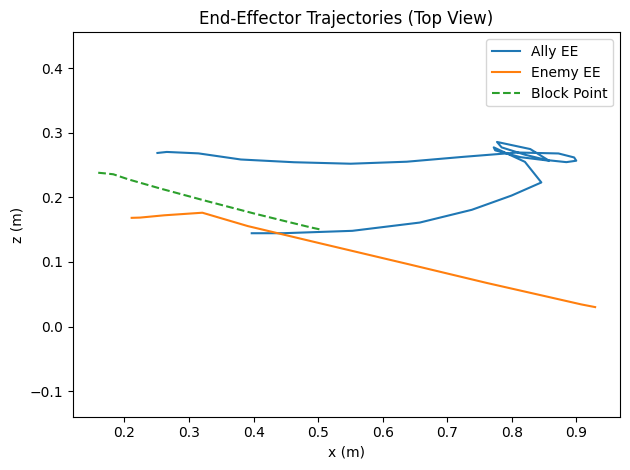

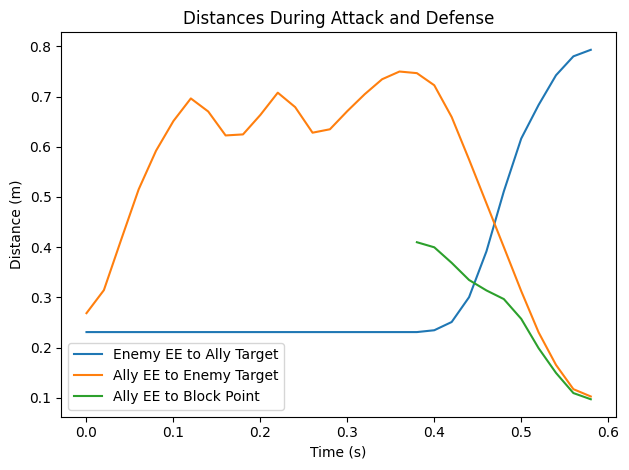

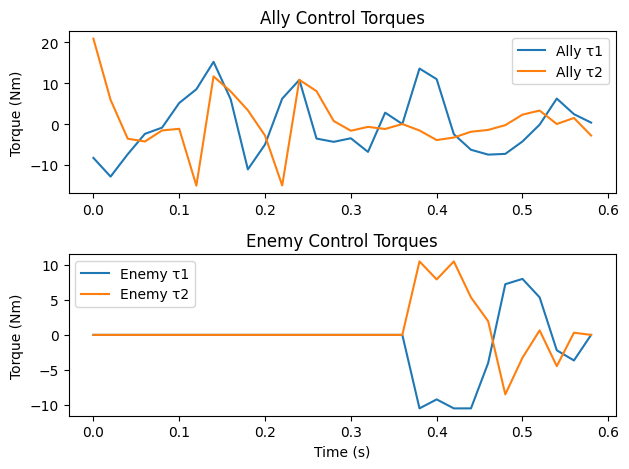

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Controllers (unchanged)
# -------------------------------------------------

# Combined scenario: ally attacks first, then enemy attacks while ally defends
ally_attack_duration = 6.0
enemy_attack_duration = 3.0

enemy_params = ArmParams(
    torque_limit=np.array([10.5, 10.5])
)

# Controllers for this sequence
ally_attack_ctrl = ILQRController(horizon=50, dt=0.02, params=params, cost=cost, verbose=False)
enemy_ctrl = ILQRController(
    horizon=50,
    dt=0.02,
    params=enemy_params,
    cost=CostParams(
        Q=np.diag([2.0, 2.0, 0.1, 0.1]),
        R=0.01 * np.eye(2),
        Qf=np.diag([50.0, 50.0, 1.0, 1.0]),
        target_weight=425.0,
        r_min=0.01,
        avoid_weight=10.0,
        avoid_sigma=0.08,
    ),
    verbose=False,
)

# Ally defense: use same controller type, but no avoidance (we WANT to block)
ally_defense_ctrl = ILQRController(
    horizon=50,
    dt=0.02,
    params=params,
    cost=CostParams(
        Q=np.diag([2.0, 2.0, 0.1, 0.1]),
        R=0.01 * np.eye(2),
        Qf=np.diag([50.0, 50.0, 1.0, 1.0]),
        target_weight=500.0,  # track blocking point strongly
        r_min=0.0,
        avoid_weight=0.0,    # no obstacle avoidance term
        avoid_sigma=0.0,
    ),
    verbose=False,
)

# Helpers

def has_hit_target(pos, target, R_target=0.1, R_ee=0.005):
    return np.linalg.norm(pos - target) <= (R_target + R_ee)

def get_block_point_2d(enemy_ee_2d: np.ndarray,
                       enemy_target_2d: np.ndarray,
                       lam: float = 0.5) -> np.ndarray:
    """
    Midpoint blocking: point between enemy EE and its target.
    lam=0.5 gives true midpoint, lam<0.5 closer to EE, lam>0.5 closer to target.
    """
    return enemy_ee_2d + lam * (enemy_target_2d - enemy_ee_2d)

def clamp_radius(p, r_min, r_max):
    r = np.linalg.norm(p)
    if r < 1e-6:
        return p
    r_clamped = np.clip(r, r_min, r_max)
    return p * (r_clamped / r)

# -------------------------------------------------
# LOGGING FOR VISUALIZATION
# -------------------------------------------------
t_log = []
ally_pos_log = []
enemy_pos_log = []
block_pos_log = []
ally_u_log = []
enemy_u_log = []
phase_log = []          # 1 = ally attack, 2 = enemy attack + ally defend
ally_hit_log = []
enemy_hit_log = []

# Reset recording
meshcat.DeleteRecording()
meshcat.StartRecording()

# ===================== Phase 1: ally attacks, enemy passive =====================
ally_u_prev = None
enemy_u_prev = None
ally_mode = "attack"
ally_phase_end = sim.get_context().get_time() + ally_attack_duration

print("Phase 1: Ally attacks, enemy passive")
while sim.get_context().get_time() < ally_phase_end:
    t = sim.get_context().get_time()

    x_ally = get_ally_state(plant, ctx, ally)
    target_pos_2d = get_ally_target_pos_2d(plant, ctx)
    enemy_pos_2d = get_enemy_pos_2d(plant, ctx)
    ally_ee_2d   = get_ally_pos_2d_from_model(x_ally, params)

    if np.any(np.isnan(x_ally)):
        print("ERROR: Ally state NaN")
        break

    hit = has_hit_target(ally_ee_2d, target_pos_2d)
    if hit:
        ally_mode = "hit"
        ally_u = np.zeros(2)
    else:
        x_pred, res = ally_attack_ctrl.step_mpc(
            x_ally,
            target_pos=target_pos_2d,
            enemy_pos=enemy_pos_2d,
            prev_u_trj=ally_u_prev,
        )
        if np.isfinite(res.cost) and res.converged:
            ally_u_prev = res.u_trj
            ally_u = res.u_trj[0]
        else:
            ally_u_prev = None
            ally_u = params.clip_u(-2.0 * x_ally[2:])

    # Enemy passive in phase 1
    u_enemy = np.zeros(2)

    # Apply torques and step simulation
    apply_combined_torques(u_ally=ally_u, u_enemy=u_enemy)
    sim.AdvanceTo(t + ally_attack_ctrl.dt)

    # LOGGING
    t_log.append(t)
    ally_pos_log.append(ally_ee_2d)
    enemy_pos_log.append(enemy_pos_2d)
    block_pos_log.append([np.nan, np.nan])  # no blocking in phase 1
    ally_u_log.append(ally_u)
    enemy_u_log.append(u_enemy)
    phase_log.append(1)
    ally_hit_log.append(hit)
    enemy_hit_log.append(False)

    if hit:
        break

# Ensure torques zeroed before next phase
apply_combined_torques(u_ally=np.zeros(2), u_enemy=np.zeros(2))
print("Phase 2: Enemy attacks, ally defends")

enemy_u_prev = None
ally_def_u_prev = None
enemy_mode = "attack"
phase2_end = sim.get_context().get_time() + enemy_attack_duration

defense_dt = min(enemy_ctrl.dt, ally_defense_ctrl.dt)
L1 = 0.6  # example, set to your values
L2 = 0.6  # example
r_max_block = 0.9 * (L1 + L2)
r_min_block = 0.15   # don't try to block closer than 15 cm from shoulder

lam_far = 0.5
lam_near = 0.8

while sim.get_context().get_time() < phase2_end:
    t = sim.get_context().get_time()

    # ---------------- Enemy state and target (Enemy frame) ----------------
    x_enemy = get_enemy_state(plant, ctx, enemy)
    enemy_target_pos_enemy = get_enemy_target_pos_2d_for_enemy(plant, ctx)   # Enemy target in Enemy frame
    ally_pos_for_enemy     = get_ally_pos_2d_for_enemy(plant, ctx)          # Ally EE in Enemy frame

    # ---------------- Ally state and enemy EE (Ally frame) ----------------
    x_ally = get_ally_state(plant, ctx, ally)
    enemy_pos_for_ally      = get_enemy_pos_2d(plant, ctx)                  # Enemy EE in Ally frame
    enemy_target_for_ally   = get_enemy_target_pos_2d_for_ally(plant, ctx)  # Enemy target in Ally frame
    ally_ee_2d              = get_ally_pos_2d_from_model(x_ally, params)

    if np.any(np.isnan(x_enemy)) or np.any(np.isnan(x_ally)):
        print("ERROR: NaN state detected; stopping phase 2")
        break

    # Check if enemy hit its target (in Enemy frame)
    enemy_ee_2d_enemy = get_enemy_pos_2d_for_enemy(plant, ctx)
    enemy_hit = has_hit_target(enemy_ee_2d_enemy, enemy_target_pos_enemy)
    if enemy_hit:
        enemy_mode = "hit"

    # ---------------- Enemy control (attack in Enemy frame) ----------------
    if enemy_mode == "attack":
        x_pred_e, res_e = enemy_ctrl.step_mpc(
            x_enemy,
            target_pos=enemy_target_pos_enemy,    # Enemy target in Enemy frame
            enemy_pos=ally_pos_for_enemy,         # Ally EE in Enemy frame
            prev_u_trj=enemy_u_prev,
        )
        if np.isfinite(res_e.cost) and res_e.converged:
            enemy_u_prev = res_e.u_trj
            u_enemy = res_e.u_trj[0]
        else:
            enemy_u_prev = None
            u_enemy = params.clip_u(-2.0 * x_enemy[2:])
    else:
        u_enemy = np.zeros(2)

    # Enemy EE and target in Ally frame (for blocking)
    enemy_pos_for_ally    = get_enemy_pos_2d(plant, ctx)
    enemy_target_for_ally = get_enemy_target_pos_2d_for_ally(plant, ctx)

    # Adaptive lam: closer to target as enemy approaches
    dist_ET = np.linalg.norm(enemy_target_for_ally - enemy_pos_for_ally)
    lam = lam_near + (lam_far - lam_near) * np.tanh(2.0 * (dist_ET - 0.2))

    raw_block = enemy_pos_for_ally + lam * (enemy_target_for_ally - enemy_pos_for_ally)
    block_pos_2d = clamp_radius(raw_block, r_min_block, r_max_block)

    x_pred_a, res_a = ally_defense_ctrl.step_mpc(
        x_ally,
        target_pos=block_pos_2d,      # Ally target in Ally frame
        enemy_pos=np.zeros(2),        # avoidance off; not used
        prev_u_trj=ally_def_u_prev,
    )

    if np.isfinite(res_a.cost) and res_a.converged:
        ally_def_u_prev = res_a.u_trj
        u_ally = res_a.u_trj[0]
    else:
        ally_def_u_prev = None
        u_ally = params.clip_u(-2.0 * x_ally[2:])

    apply_combined_torques(u_ally=u_ally, u_enemy=u_enemy)
    sim.AdvanceTo(t + defense_dt)

    # LOGGING
    t_log.append(t)
    ally_pos_log.append(ally_ee_2d)
    enemy_pos_log.append(enemy_pos_for_ally)
    block_pos_log.append(block_pos_2d)
    ally_u_log.append(u_ally)
    enemy_u_log.append(u_enemy)
    phase_log.append(2)
    ally_hit_log.append(False)
    enemy_hit_log.append(enemy_hit)

    if enemy_hit:
        break

# Stop and publish recording
apply_combined_torques(u_ally=np.zeros(2), u_enemy=np.zeros(2))
meshcat.StopRecording()
meshcat.PublishRecording()
print("Combined scenario complete.")

# -------------------------------------------------
# VISUALIZATION FOR POSTER FIGURES
# -------------------------------------------------
t_arr = np.array(t_log)
ally_pos_arr = np.array(ally_pos_log)       # shape (N,2)
enemy_pos_arr = np.array(enemy_pos_log)     # shape (N,2)
block_pos_arr = np.array(block_pos_log)     # shape (N,2)
ally_u_arr = np.array(ally_u_log)           # shape (N,2)
enemy_u_arr = np.array(enemy_u_log)         # shape (N,2)
phase_arr = np.array(phase_log)
ally_hit_arr = np.array(ally_hit_log)
enemy_hit_arr = np.array(enemy_hit_log)

# 1) Top-down trajectories of Ally, Enemy, and block point
plt.figure()
plt.plot(ally_pos_arr[:,0], ally_pos_arr[:,1], label="Ally EE")
plt.plot(enemy_pos_arr[:,0], enemy_pos_arr[:,1], label="Enemy EE")
plt.plot(block_pos_arr[:,0], block_pos_arr[:,1], label="Block Point", linestyle="--")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.axis("equal")
plt.legend()
plt.title("End-Effector Trajectories (Top View)")
plt.tight_layout()
plt.savefig("traj_topdown.png", dpi=300)

# 2) Distance to targets / blocking point over time
# (Requires known target positions in Ally frame; replace with your functions if needed)
ally_target = get_ally_target_pos_2d(plant, ctx)            # for plotting reference
enemy_target_for_ally = get_enemy_target_pos_2d_for_ally(plant, ctx)

dist_ally_to_enemy_target = np.linalg.norm(ally_pos_arr - enemy_target_for_ally, axis=1)
dist_enemy_to_ally_target = np.linalg.norm(enemy_pos_arr - ally_target, axis=1)
dist_ally_to_block = np.linalg.norm(ally_pos_arr - block_pos_arr, axis=1)

plt.figure()
plt.plot(t_arr, dist_enemy_to_ally_target, label="Enemy EE to Ally Target")
plt.plot(t_arr, dist_ally_to_enemy_target, label="Ally EE to Enemy Target")
plt.plot(t_arr, dist_ally_to_block, label="Ally EE to Block Point")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.title("Distances During Attack and Defense")
plt.tight_layout()
plt.savefig("distances.png", dpi=300)

# 3) Joint torques over time (Ally and Enemy)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_arr, ally_u_arr[:,0], label="Ally τ1")
plt.plot(t_arr, ally_u_arr[:,1], label="Ally τ2")
plt.ylabel("Torque (Nm)")
plt.title("Ally Control Torques")
plt.legend()

plt.subplot(2,1,2)
plt.plot(t_arr, enemy_u_arr[:,0], label="Enemy τ1")
plt.plot(t_arr, enemy_u_arr[:,1], label="Enemy τ2")
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.title("Enemy Control Torques")
plt.legend()

plt.tight_layout()
plt.savefig("torques.png", dpi=300)

print("Saved figures: traj_topdown.png, distances.png, torques.png")


In [62]:
meshcat.PublishRecording()

In [ ]:
# Combined scenario: ally attacks first, then enemy attacks while ally defends
ally_attack_duration = 6.0
enemy_attack_duration = 8.0

enemy_params = ArmParams(
    torque_limit=np.array([1.5, 1.5])
)

# Controllers for this sequence
ally_attack_ctrl = ILQRController(horizon=50, dt=0.02, params=params, cost=cost, verbose=False)
enemy_ctrl = ILQRController(
    horizon=50,
    dt=0.02,
    params=enemy_params,
    cost=CostParams(
        Q=np.diag([2.0, 2.0, 0.1, 0.1]),
        R=0.01 * np.eye(2),
        Qf=np.diag([50.0, 50.0, 1.0, 1.0]),
        target_weight=425.0,
        r_min=0.01,
        avoid_weight=10.0,
        avoid_sigma=0.08,
    ),
    verbose=False,
)

# Ally defense: use same controller type, but no avoidance (we WANT to block)
ally_defense_ctrl = ILQRController(
    horizon=50,
    dt=0.02,
    params=params,
    cost=CostParams(
        Q=np.diag([2.0, 2.0, 0.1, 0.1]),
        R=0.01 * np.eye(2),
        Qf=np.diag([50.0, 50.0, 1.0, 1.0]),
        target_weight=500.0,  # track blocking point strongly
        r_min=0.0,
        avoid_weight=0.0,    # no obstacle avoidance term
        avoid_sigma=0.0,
    ),
    verbose=False,
)

# Helpers

def has_hit_target(pos, target, R_target=0.1, R_ee=0.005):
    return np.linalg.norm(pos - target) <= (R_target + R_ee)

def get_block_point_2d(enemy_ee_2d: np.ndarray,
                       enemy_target_2d: np.ndarray,
                       lam: float = 0.5) -> np.ndarray:
    """
    Midpoint blocking: point between enemy EE and its target.
    lam=0.5 gives true midpoint, lam<0.5 closer to EE, lam>0.5 closer to target.
    """
    return enemy_ee_2d + lam * (enemy_target_2d - enemy_ee_2d)


# Reset recording
meshcat.DeleteRecording()
meshcat.StartRecording()

# ===================== Phase 1: ally attacks, enemy passive =====================
ally_u_prev = None
enemy_u_prev = None
ally_mode = "attack"
ally_phase_end = sim.get_context().get_time() + ally_attack_duration

print("Phase 1: Ally attacks, enemy passive")
while sim.get_context().get_time() < ally_phase_end:
    x_ally = get_ally_state(plant, ctx, ally)
    target_pos_2d = get_ally_target_pos_2d(plant, ctx)
    enemy_pos_2d = get_enemy_pos_2d(plant, ctx)

    if np.any(np.isnan(x_ally)):
        print("ERROR: Ally state NaN")
        break

    hit = has_hit_target(get_ally_pos_2d_from_model(x_ally, params), target_pos_2d)
    if hit:
        ally_mode = "hit"
        ally_u = np.zeros(2)
    else:
        x_pred, res = ally_attack_ctrl.step_mpc(
            x_ally,
            target_pos=target_pos_2d,
            enemy_pos=enemy_pos_2d,
            prev_u_trj=ally_u_prev,
        )
        if np.isfinite(res.cost) and res.converged:
            ally_u_prev = res.u_trj
            ally_u = res.u_trj[0]
        else:
            ally_u_prev = None
            ally_u = params.clip_u(-2.0 * x_ally[2:])

    apply_combined_torques(u_ally=ally_u, u_enemy=np.zeros(2))
    sim.AdvanceTo(sim.get_context().get_time() + ally_attack_ctrl.dt)

    if hit:
        break

# Ensure torques zeroed before next phase
apply_combined_torques(u_ally=np.zeros(2), u_enemy=np.zeros(2))
print("Phase 2: Enemy attacks, ally defends")

enemy_u_prev = None
ally_def_u_prev = None
enemy_mode = "attack"
phase2_end = sim.get_context().get_time() + enemy_attack_duration

defense_dt = min(enemy_ctrl.dt, ally_defense_ctrl.dt)
def clamp_radius(p, r_min, r_max):
    r = np.linalg.norm(p)
    if r < 1e-6:
        return p
    r_clamped = np.clip(r, r_min, r_max)
    return p * (r_clamped / r)

while sim.get_context().get_time() < phase2_end:
    # ---------------- Enemy state and target (Enemy frame) ----------------
    x_enemy = get_enemy_state(plant, ctx, enemy)
    enemy_target_pos_enemy = get_enemy_target_pos_2d_for_enemy(plant, ctx)   # Enemy target in Enemy frame
    ally_pos_for_enemy     = get_ally_pos_2d_for_enemy(plant, ctx)          # Ally EE in Enemy frame

    # ---------------- Ally state and enemy EE (Ally frame) ----------------
    x_ally = get_ally_state(plant, ctx, ally)
    enemy_pos_for_ally      = get_enemy_pos_2d(plant, ctx)                  # Enemy EE in Ally frame
    enemy_target_for_ally   = get_enemy_target_pos_2d_for_ally(plant, ctx)  # Enemy target in Ally frame

    if np.any(np.isnan(x_enemy)) or np.any(np.isnan(x_ally)):
        print("ERROR: NaN state detected; stopping phase 2")
        break

    # Check if enemy hit its target (in Enemy frame)
    enemy_ee_2d_enemy = get_enemy_pos_2d_for_enemy(plant, ctx)
    enemy_hit = has_hit_target(enemy_ee_2d_enemy, enemy_target_pos_enemy)
    if enemy_hit:
        enemy_mode = "hit"

    # ---------------- Enemy control (attack in Enemy frame) ----------------
    if enemy_mode == "attack":
        x_pred_e, res_e = enemy_ctrl.step_mpc(
            x_enemy,
            target_pos=enemy_target_pos_enemy,    # Enemy target in Enemy frame
            enemy_pos=ally_pos_for_enemy,         # Ally EE in Enemy frame
            prev_u_trj=enemy_u_prev,
        )
        if np.isfinite(res_e.cost) and res_e.converged:
            enemy_u_prev = res_e.u_trj
            u_enemy = res_e.u_trj[0]
        else:
            enemy_u_prev = None
            u_enemy = params.clip_u(-2.0 * x_enemy[2:])
    else:
        u_enemy = np.zeros(2)

    # Enemy EE and target in Ally frame
    enemy_pos_for_ally    = get_enemy_pos_2d(plant, ctx)
    enemy_target_for_ally = get_enemy_target_pos_2d_for_ally(plant, ctx)
    L1 = 0.6  # example, set to your values
    L2 = 0.6  # example
    r_max_block = 0.9 * (L1 + L2)
    r_min_block = 0.15   # don't try to block closer than 15 cm from shoulder

    # Adaptive lam: closer to target as enemy approaches
    dist_ET = np.linalg.norm(enemy_target_for_ally - enemy_pos_for_ally)
    lam_far = 0.5
    lam_near = 0.8
    # Smoothly move lam from 0.5 (far) to 0.8 (near)
    lam = lam_near + (lam_far - lam_near) * np.tanh(2.0 * (dist_ET - 0.2))

    raw_block = enemy_pos_for_ally + lam * (enemy_target_for_ally - enemy_pos_for_ally)
    block_pos_2d = clamp_radius(raw_block, r_min_block, r_max_block)

    print("Enemy EE (ally frame):", enemy_pos_for_ally)
    print("Enemy target (ally frame):", enemy_target_for_ally)
    print("Block point (ally frame):", block_pos_2d)


    x_pred_a, res_a = ally_defense_ctrl.step_mpc(
        x_ally,
        target_pos=block_pos_2d,      # Ally target in Ally frame
        enemy_pos=np.zeros(2),        # avoidance off; not used
        prev_u_trj=ally_def_u_prev,
    )

    if np.isfinite(res_a.cost) and res_a.converged:
        ally_def_u_prev = res_a.u_trj
        u_ally = res_a.u_trj[0]
    else:
        ally_def_u_prev = None
        u_ally = params.clip_u(-2.0 * x_ally[2:])

    apply_combined_torques(u_ally=u_ally, u_enemy=u_enemy)
    sim.AdvanceTo(sim.get_context().get_time() + defense_dt)

    if enemy_hit:
        break

# Stop and publish recording
apply_combined_torques(u_ally=np.zeros(2), u_enemy=np.zeros(2))
meshcat.StopRecording()
meshcat.PublishRecording()
print("Combined scenario complete.")


Phase 1: Ally attacks, enemy passive
Phase 2: Enemy attacks, ally defends
Enemy EE (ally frame): [0.92898993 0.03015369]
Enemy target (ally frame): [0.15 0.25]
Block point (ally frame): [0.50194233 0.15067494]
Enemy EE (ally frame): [0.9259293  0.03074837]
Enemy target (ally frame): [0.15 0.25]
Block point (ally frame): [0.50012979 0.15106505]
Enemy EE (ally frame): [0.9236301  0.03190807]
Enemy target (ally frame): [0.15 0.25]
Block point (ally frame): [0.4987404  0.15168756]
Enemy EE (ally frame): [0.92125158 0.03366195]
Enemy target (ally frame): [0.15 0.25]
Block point (ally frame): [0.4972811  0.15258676]
Enemy EE (ally frame): [0.9181961  0.03533211]
Enemy target (ally frame): [0.15 0.25]
Block point (ally frame): [0.49542723 0.15347239]
Enemy EE (ally frame): [0.91396282 0.03706169]
Enemy target (ally frame): [0.15 0.25]
Block point (ally frame): [0.4928787  0.15442989]
Enemy EE (ally frame): [0.90167089 0.03839693]
Enemy target (ally frame): [0.15 0.25]
Block point (ally frame)

In [48]:
meshcat.PublishRecording()

### Define Global Parameters

In [16]:
# Default Parameters 
params = ArmParams()

# Default cost parameters
cost = CostParams(
    Q=np.diag([2.0, 2.0, 0.1, 0.1]),
    R=0.01 * np.eye(2),
    Qf=np.diag([50.0, 50.0, 1.0, 1.0]),
    target_weight=425.0,
    r_min=0.01, # Turning off Exponential Cost at a certain distance
    avoid_weight=30.0,
    avoid_sigma=0.08,
)

dt_mpc = 0.02  # CHANGED: 0.05 is too large for stable feedback on this arm
horizon = 50   # Adjusted horizon to match new dt (50 * 0.02 = 1.0s lookahead)

ctrl = ILQRController(
    horizon=horizon,
    dt=dt_mpc,
    params=params,
    cost=cost,
    verbose=False,
)

### Run Simulation

In [21]:
# Ally starts from a fixed configuration for repeatability
ally_angles = np.deg2rad([45.0, -130.0])
set_angles_for_instance(plant, ctx, ally, ally_angles)

enemy_config_mode = "random"  # options: "random", "default", "custom"
custom_enemy_degs = [90.0, -150.0]

# Enemy configuration selection
if enemy_config_mode == "random":
    enemy_angles = randomize_enemy_configuration()
elif enemy_config_mode == "default":
    enemy_angles = np.deg2rad([45.0, -140.0])
elif enemy_config_mode == "custom":
    enemy_angles = np.deg2rad(custom_enemy_degs)
else:
    raise ValueError(f"Unknown enemy_config_mode: {enemy_config_mode}")
print("Enemy start angles (deg):", np.rad2deg(enemy_angles))
set_angles_for_instance(plant, ctx, enemy, enemy_angles)

sim.AdvanceTo(0.0)
print("Done.")

Enemy randomized in 1 tries.
Enemy start angles (deg): [-21.13087712 161.74348224]
Done.


In [ ]:

meshcat.PublishRecording()

In [81]:
import time

t_final = 10.0
dt_ctrl = ctrl.dt
base_avoid_weight = cost.avoid_weight
avoid_decay_time = 5.0  # seconds to significantly reduce avoidance weight
min_avoid_scale = 0.1

t = sim.get_context().get_time()
u_traj_prev = None
step = 0
mode = "mpc"  # start in MPC mode

print("Starting MPC loop...")

def has_reached_target(ally_pos, target_pos, x,
                       R_target=0.1,
                       R_ally=0.005,
                       vel_tol=0.1):

    # distance between centers in task space
    pos_err = np.linalg.norm(ally_pos - target_pos)

    # geometric contact threshold
    contact_dist = R_target + R_ally

    return pos_err <= contact_dist


while t < t_final:
    # 1) Current state
    x_current = get_ally_state(plant, ctx, ally)

    # 2) Positions
    target_pos_2d = get_target_pos_2d(plant, ctx)
    enemy_pos_2d  = get_enemy_pos_2d(plant, ctx)
    ally_pos_2d   = get_ally_pos_2d_from_model(x_current, params)

    print("target positions: ", target_pos_2d)
    print("enemy positions: ", enemy_pos_2d)
    print("ally positions: ", ally_pos_2d)

    # 3) Check for NaN in state (Simulation exploded)
    if np.any(np.isnan(x_current)):
        print("ERROR: Simulation state is NaN. Physics exploded.")
        break

    # 4) Check target hit and switch to passive mode (one-way)
    if mode == "mpc" and has_reached_target(ally_pos_2d, target_pos_2d, x_current):
        print(f"\n*** Target reached at t={t:.2f}s ***")
        print(f"ally EE pos: {ally_pos_2d}, target: {target_pos_2d}")
        print("*** Target reached; switching to passive mode ***")
        mode = "passive"

    # 5) Control law: MPC vs passive. Can change this to 'attack' / 'defense' next
    if mode == "mpc":
        # Decay enemy-avoidance weight over time
        decay = np.exp(-t / avoid_decay_time)
        avoid_scale = max(min_avoid_scale, decay)
        ctrl.cost.avoid_weight = base_avoid_weight * avoid_scale

        # MPC step
        x_pred, result = ctrl.step_mpc(
            x_current,
            target_pos=target_pos_2d,
            enemy_pos=enemy_pos_2d,
            prev_u_trj=u_traj_prev,
        )

        if np.isfinite(result.cost) and result.converged:
            u_traj_prev = result.u_trj
            u0 = result.u_trj[0]
        else:
            print(f"[Warning] iLQR failed (cost: {result.cost}, conv: {result.converged}). Braking.")
            # Damping torque to stop robot if controller fails
            u0 = params.clip_u(-2.0 * x_current[2:])
            u_traj_prev = None  # Reset warm start
    else:
        # Passive after hit: zero (or damping) torques
        # You can replace np.zeros(2) by a damping law if you want.

        # change here or new mode ==
        u0 = np.zeros(2)


    # 6) Debug prints
    if step % 5 == 0:
        if mode == "mpc":
            dbg_cost = result.cost
            dbg_avoid = ctrl.cost.avoid_weight
        else:
            dbg_cost = float("nan")
            dbg_avoid = ctrl.cost.avoid_weight  # last value from MPC phase

        print(
            f"t={t:.3f} | mode={mode} | "
            f"x={np.array2string(x_current, precision=2)} | "
            f"cost={dbg_cost:.1f} | avoid_w={dbg_avoid:.1f} | "
            f"u0={np.array2string(u0, precision=2)}"
        )

    # 7) Apply control and advance sim
    apply_ally_torque(plant, ctx, ally, u0)
    sim.AdvanceTo(t + dt_ctrl)
    t = sim.get_context().get_time()
    step += 1

print("MPC run complete.")


Starting MPC loop...
target positions:  [1.   0.25]
enemy positions:  [0.17701485 0.14338253]
ally positions:  [0.25888487 0.44099061]
t=0.620 | mode=mpc | x=[-2.07  2.07 -1.78 -1.09] | cost=12171.2 | avoid_w=26.5 | u0=[25.91  3.14]
target positions:  [1.   0.25]
enemy positions:  [0.17824048 0.13143645]
ally positions:  [0.26496724 0.44458277]
target positions:  [1.   0.25]
enemy positions:  [0.17868746 0.11892576]
ally positions:  [0.33293606 0.42795168]
target positions:  [1.   0.25]
enemy positions:  [0.17855913 0.1059811 ]
ally positions:  [0.46058165 0.41140205]
target positions:  [1.   0.25]
enemy positions:  [0.17801495 0.09269871]
ally positions:  [0.59339774 0.38560039]
target positions:  [1.   0.25]
enemy positions:  [0.17718167 0.07915244]
ally positions:  [0.6935155 0.3450005]
t=0.720 | mode=mpc | x=[-1.15  1.37  9.3  -8.83] | cost=10691.4 | avoid_w=26.0 | u0=[-18.19   1.59]
target positions:  [1.   0.25]
enemy positions:  [0.17616099 0.06540087]
ally positions:  [0.758235

KeyboardInterrupt: 

In [ ]:
# Enemy attack controller (run this cell to let the enemy strike back)
enemy_attack_duration = 8.0

enemy_cost = CostParams(
    Q=np.diag([2.0, 2.0, 0.1, 0.1]),
    R=0.01 * np.eye(2),
    Qf=np.diag([50.0, 50.0, 1.0, 1.0]),
    target_weight=425.0,
    r_min=0.01,
    avoid_weight=30.0,
    avoid_sigma=0.08,
)

enemy_ctrl = ILQRController(
    horizon=50,
    dt=0.02,
    params=params,
    cost=enemy_cost,
    verbose=True,
)

base_enemy_avoid_weight = enemy_cost.avoid_weight
enemy_avoid_decay_time = 5.0
enemy_min_avoid_scale = 0.1
enemy_u_traj_prev = None
enemy_mode = "mpc"

enemy_t_start = sim.get_context().get_time()
enemy_t_final = enemy_t_start + enemy_attack_duration
enemy_t = enemy_t_start
enemy_step = 0
result = None

print("Starting ENEMY MPC loop...")
apply_combined_torques(u_ally=np.zeros(2), u_enemy=np.zeros(2))


def has_enemy_reached_target(enemy_pos, target_pos, x,
                             R_target=0.1,
                             R_enemy=0.005,
                             vel_tol=0.1):
    pos_err = np.linalg.norm(enemy_pos - target_pos)
    contact_dist = R_target + R_enemy
    vel_norm = np.linalg.norm(x[2:])
    return pos_err <= contact_dist and vel_norm < vel_tol


while enemy_t < enemy_t_final:
    x_enemy = get_enemy_state(plant, ctx, enemy)
    enemy_pos_2d = get_enemy_pos_2d_for_enemy(plant, ctx)
    target_pos_2d = get_enemy_target_pos_2d_for_enemy(plant, ctx)
    ally_pos_2d = get_ally_pos_2d_for_enemy(plant, ctx)

    if np.any(np.isnan(x_enemy)):
        print("ERROR: Enemy state is NaN. Stopping enemy controller.")
        break

    if enemy_mode == "mpc" and has_enemy_reached_target(enemy_pos_2d, target_pos_2d, x_enemy):
        print(f"*** Enemy target reached at t={enemy_t:.2f}s ***")
        print(f"enemy EE pos: {enemy_pos_2d}, target: {target_pos_2d}")
        enemy_mode = "passive"
        enemy_u_traj_prev = None

    if enemy_mode == "mpc":
        elapsed = enemy_t - enemy_t_start
        decay = np.exp(-elapsed / enemy_avoid_decay_time)
        avoid_scale = max(enemy_min_avoid_scale, decay)
        enemy_ctrl.cost.avoid_weight = base_enemy_avoid_weight * avoid_scale

        x_pred, result = enemy_ctrl.step_mpc(
            x_enemy,
            target_pos=target_pos_2d,
            enemy_pos=ally_pos_2d,
            prev_u_trj=enemy_u_traj_prev,
        )

        if np.isfinite(result.cost) and result.converged:
            enemy_u_traj_prev = result.u_trj
            u0 = result.u_trj[0]
        else:
            print(f"[Enemy Warning] iLQR failed (cost: {result.cost}, conv: {result.converged}). Braking.")
            u0 = params.clip_u(-2.0 * x_enemy[2:])
            enemy_u_traj_prev = None
    else:
        u0 = np.zeros(2)

    if enemy_step % 5 == 0:
        if enemy_mode == "mpc" and result is not None:
            dbg_cost = result.cost
            dbg_avoid = enemy_ctrl.cost.avoid_weight
        else:
            dbg_cost = float("nan")
            dbg_avoid = enemy_ctrl.cost.avoid_weight

        print(
            f"t={enemy_t:.3f} | mode={enemy_mode} | "
            f"x={np.array2string(x_enemy, precision=2)} | "
            f"cost={dbg_cost:.1f} | avoid_w={dbg_avoid:.1f} | "
            f"u0={np.array2string(u0, precision=2)}"
        )

    apply_combined_torques(u_ally=np.zeros(2), u_enemy=u0)
    sim.AdvanceTo(enemy_t + enemy_ctrl.dt)
    enemy_t = sim.get_context().get_time()
    enemy_step += 1

apply_combined_torques(u_ally=np.zeros(2), u_enemy=np.zeros(2))
print("Enemy MPC run complete.")





NameError: name 'CostParams' is not defined

In [31]:
meshcat.PublishRecording()